In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (10, 5)}, font_scale=1.5)

df = pd.read_csv('/content/drive/MyDrive/ECH_2019.csv')

# df = pd.read_csv('ECH_2019.csv')

In [3]:
df.sample(2)

,sexo,edad,ascendencia,parentesco,estado_laboral,sueldo,busca_otro_trabajo,actividad,asistencia alguna vez a enseñanza,edu preescolar,edu primaria,edu media,edu técnica,edu univ o simil,edu terciario no uni,edu posgrado,edu mag prof,barrio,estado_civil,hijos,hijos en hogar,hijos en otro hogar,hijos en el extranjero,leer_escribir,suma_hijos
29507,Hombre,55,Blanca,Jefe/a de hogar,Ocupados,0,No,Cría de ganado vacuno y búfalos,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,0,0,0,0,0,Casado/a (incluye separado/a y aún no se divor...,0,0,0,0,Sí,0
31540,Hombre,32,Blanca,Esposo/a o compañero/a,Ocupados,35000,No,Actividades de organizaciones empresariales y ...,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,"Sí, asistió",No asistió,No asistió,No asistió,8,0,0,0,0,0,Sí,0


In [4]:
no_data = {0: 'No hay dato', '0': 'No hay dato'}

mask = df.columns.difference(['edad',
                              'sueldo',
                              'hijos en hogar',
                              'hijos en otro hogar',
                              'hijos en el extranjero',
                              'suma_hijos',
                              'barrio'])

df[mask] = df[mask].replace(no_data)

In [5]:
df['rango_edades'] = pd.qcut(df['edad'], q=10)

df['rango_edades'].value_counts()

(8.0, 16.0]      11803
(39.0, 47.0]     11347
(63.0, 73.0]     10988
(-0.001, 8.0]    10918
(55.0, 63.0]     10848
(47.0, 55.0]     10834
(16.0, 23.0]     10657
(31.0, 39.0]     10484
(23.0, 31.0]     10116
(73.0, 98.0]      9876
Name: rango_edades, dtype: int64

### AJUSTANDO DATOS PARA ENTRENAR EL MODELO

Seleccionamos personas con edad suficiente para trabajar

In [6]:
df = df[~df['estado_laboral'].str.contains('Menores de 14 años')]

In [7]:
df = df[df["sueldo"] > 0]

In [8]:
df.groupby(by='estado_laboral').mean()

,edad,sueldo,barrio,hijos en hogar,hijos en otro hogar,hijos en el extranjero,suma_hijos
estado_laboral,,,,,,,
Desocupados buscan trabajo por primera vez,28.500000,9850.000000,15.000000,0.000000,0.000000,0.000000,0.000000
Desocupados en seguro de paro,36.600000,22965.400000,10.800000,0.400000,0.275000,0.050000,0.725000
Desocupados propiamente dichos,31.810219,12931.180049,10.184915,0.403893,0.228710,0.002433,0.635036
Inactivo: estudiante,22.087719,13498.245614,9.754386,0.105263,0.052632,0.000000,0.157895
Inactivo: jubilado,63.148936,42102.127660,11.574468,0.361702,0.659574,0.085106,1.106383
Inactivo: otro,31.355556,17732.444444,8.911111,0.200000,0.044444,0.000000,0.244444
Inactivo: pensionista,59.444444,11222.222222,6.000000,0.888889,1.555556,0.333333,2.777778
Inactivo: realiza los quehaceres del hogar,39.066038,17799.245283,12.462264,1.066038,0.320755,0.028302,1.415094
Inactivo: rentista,36.000000,30000.000000,8.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
df['rango_sueldos'] = pd.qcut(df['sueldo'], q=10, duplicates='drop')

df['rango_sueldos'].value_counts()

(9000.0, 15000.0]      4421
(32000.0, 40000.0]     3976
(24000.0, 28000.0]     3971
(199.999, 9000.0]      3620
(28000.0, 32000.0]     3351
(20000.0, 24000.0]     3316
(50000.0, 900000.0]    3257
(15000.0, 18000.0]     3165
(18000.0, 20000.0]     2878
(40000.0, 50000.0]     2610
Name: rango_sueldos, dtype: int64

In [10]:
quantil_99 = df["sueldo"].quantile(0.99)
print(quantil_99)

df = df[df["sueldo"] < quantil_99]

quartil_1 = df["sueldo"].quantile(0.25)
quartil_3 = df["sueldo"].quantile(0.75)

iqr = quartil_3 - quartil_1

df = df[df["sueldo"] < quartil_3 + 1.5 * iqr]

df = df[df["sueldo"] > quartil_1 - 1.5 * iqr]

120000.0


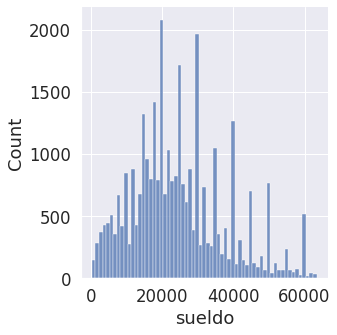

In [11]:
sns.displot(df['sueldo'])

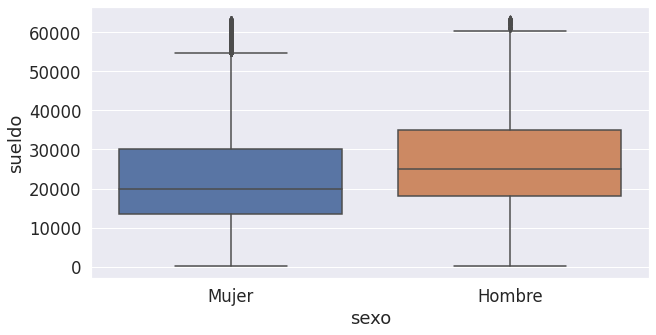

In [12]:
sns.boxplot(data=df, x='sexo', y='sueldo')

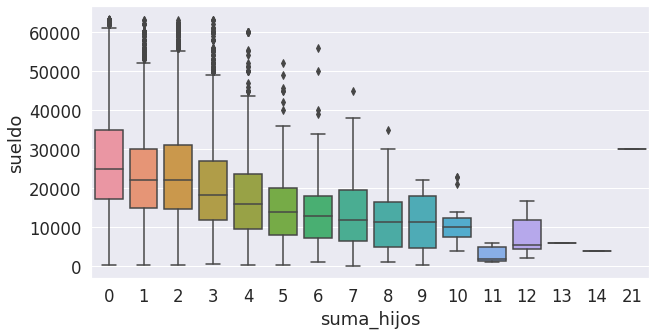

In [13]:
sns.boxplot(data=df, x='suma_hijos', y='sueldo')

# Categorizamos las edades y sueldos en rangos

In [14]:
df['rango_sueldos'] = pd.qcut(df['sueldo'], q=10).cat.codes

df['rango_edades'] = pd.qcut(df['edad'], q=10).cat.codes

Eliminanos las columnas que no vamos a usar o que ya categorizamos

In [15]:
df = df[[
    'sexo', 
    'edad', 
    'ascendencia', 
    'parentesco', 
    'estado_laboral', 
    'sueldo', 
    'busca_otro_trabajo',
    'actividad',
    'asistencia alguna vez a enseñanza',
    'edu preescolar',
    'edu primaria',
    'edu media',
    'edu técnica',
    'edu univ o simil',
    'edu terciario no uni',
    'edu posgrado',
    'edu mag prof',
    'barrio',
    'estado_civil',
    'suma_hijos',
    'leer_escribir',
    'rango_sueldos',
    'rango_edades'
    ]]

### DEFINIMOS LAS VARIABLES DEPENDIENTES E INDEPENDIENTES

In [16]:
# Feautures
X = df.drop('rango_sueldos', axis=1).to_numpy()
y = df['rango_sueldos']

print('X shape', X.shape, '\nY shape', y.shape)

X shape (32661, 22) 
Y shape (32661,)


In [17]:
y.unique()

array([2, 1, 6, 5, 0, 8, 3, 4, 7, 9], dtype=int8)

In [18]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()

X = one_hot.fit_transform(X)

In [19]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

X = normalizer.fit_transform(X)

X.toarray()

array([[0.        , 0.21320072, 0.        , ..., 0.        , 0.        ,
        0.21320072],
       [0.        , 0.21320072, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.21320072, 0.        , ..., 0.21320072, 0.        ,
        0.        ],
       ...,
       [0.        , 0.21320072, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21320072, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21320072, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Dividimos los datos en un 30% de test y 70% de entrenamiento

In [20]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 

In [21]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(22862, 1679) (22862,)
(9799, 1679) (9799,)


In [22]:
to_test_predict = X_train.toarray()[145].reshape(1, -1)

print(to_test_predict)

prediction_result = y_train.iloc[145]

print(prediction_result)

[[0.21320072 0.         0.         ... 0.         0.         0.        ]]
3


# DEFINIMOS ALGORITMO DE REGRESIÓN LOGISTICA

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logistic_reg = LogisticRegression(multi_class='multinomial', max_iter=20000)

logistic_reg.fit(X_train, y_train)

LogisticRegression(max_iter=20000, multi_class='multinomial')

### VALOR DE CROSS VALIDATION PARA CADA FOLD

In [24]:
scores = cross_val_score(logistic_reg, X, y, cv=5)

scores

array([0.94673198, 0.94565217, 0.94442743, 0.94947949, 0.94243723])

In [25]:
print('Promedio de cross_validation ', round(scores.mean(),2))
print('Score en test ', round(logistic_reg.score(X_test, y_test),2))
print('Score en train ', round(logistic_reg.score(X_train, y_train),2))

Promedio de cross_validation  0.95
Score en test  0.94
Score en train  0.95


In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

predictions = logistic_reg.predict(X_test)

confusion_matrix(y_test, predictions)

array([[ 936,    5,    1,    1,    2,    0,    0,    1,    8,   17],
       [  77,  981,    0,    2,    0,    0,    0,    0,    4,   11],
       [  33,   12,  841,    6,    0,    0,    0,    0,   13,   12],
       [  30,    7,    0, 1223,    2,    0,    1,    0,    9,   10],
       [  18,    5,    0,    5,  688,    0,    1,    0,   14,    6],
       [  24,   11,    0,    5,    3,  911,    2,    0,   14,    6],
       [  18,    6,    0,    3,    0,    1, 1097,    0,   28,   14],
       [  10,    5,    1,    1,    0,    0,    0,  738,   20,   19],
       [   7,    0,    0,    1,    1,    0,    0,    0, 1088,   22],
       [   4,    0,    0,    1,    0,    0,    0,    0,    8,  748]])

### INVESTIGAMOS LA EFECTIVIDAD DEL MODELO SOBRE LOS DATOS

In [27]:
from sklearn.metrics import accuracy_score

#Prediccion en Train
y_train_pred = logistic_reg.predict(X_train)

#Prediccion en Test
y_test_pred = logistic_reg.predict(X_test)

#Calculo el accuracy en Train
train_accuracy = accuracy_score(y_train, y_train_pred)

#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Aciertos sobre entrenamiento:', round(train_accuracy, 2))
print('Aciertos sobre evaluación:', round(test_accuracy, 2))

Aciertos sobre entrenamiento: 0.95
Aciertos sobre evaluación: 0.94


In [28]:
y_train

60289    3
71191    0
78172    1
17837    5
4426     4
        ..
98321    2
17937    9
2936     3
52432    5
78317    6
Name: rango_sueldos, Length: 22862, dtype: int8

### APLICAMOS PREDICCIÓN SOBRE EL MODELO

In [29]:
print(logistic_reg.predict(to_test_predict))

print(prediction_result)

[3]
3


Determinamos la probabilidad de la predicción

In [30]:
probabilidades_prediccion = logistic_reg.predict_proba(to_test_predict)
probabilidades_prediccion[:,1]

array([0.00650463])

# REPETIMOS EL EJERCICIO CON EL MODELO DE RANDOM FOREST

In [31]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(100)

random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [32]:
scores = cross_val_score(random_forest, X, y, cv=5)

scores

array([0.93448645, 0.93355787, 0.93554807, 0.93631353, 0.93156767])

In [33]:
print('Promedio de cross_validation ', round(scores.mean(),2))
print('Score en test ', round(logistic_reg.score(X_test, y_test),2))
print('Score en train ', round(logistic_reg.score(X_train, y_train),2))

Promedio de cross_validation  0.93
Score en test  0.94
Score en train  0.95


In [34]:
predictions = logistic_reg.predict(X_test)

confusion_matrix(y_test, predictions)

array([[ 936,    5,    1,    1,    2,    0,    0,    1,    8,   17],
       [  77,  981,    0,    2,    0,    0,    0,    0,    4,   11],
       [  33,   12,  841,    6,    0,    0,    0,    0,   13,   12],
       [  30,    7,    0, 1223,    2,    0,    1,    0,    9,   10],
       [  18,    5,    0,    5,  688,    0,    1,    0,   14,    6],
       [  24,   11,    0,    5,    3,  911,    2,    0,   14,    6],
       [  18,    6,    0,    3,    0,    1, 1097,    0,   28,   14],
       [  10,    5,    1,    1,    0,    0,    0,  738,   20,   19],
       [   7,    0,    0,    1,    1,    0,    0,    0, 1088,   22],
       [   4,    0,    0,    1,    0,    0,    0,    0,    8,  748]])

In [35]:
#Prediccion en Train
y_train_pred = random_forest.predict(X_train)

#Prediccion en Test
y_test_pred = random_forest.predict(X_test)

#Calculo el accuracy en Train
train_accuracy = accuracy_score(y_train, y_train_pred)

#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Aciertos sobre entrenamiento:', round(train_accuracy, 2))
print('Aciertos sobre evaluación:', round(test_accuracy, 2))

Aciertos sobre entrenamiento: 1.0
Aciertos sobre evaluación: 0.93


In [36]:
print(random_forest.predict(to_test_predict))
print(prediction_result)

[3]
3


# REPETIMOS EL EJERCICIO CON EL MODELO DE K NEAREST NEIGHBOURS

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knearest_model = KNeighborsClassifier(n_neighbors=4)

knearest_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [38]:
scores = cross_val_score(knearest_model, X, y, cv=5)

scores           

array([0.43180775, 0.42498469, 0.43049602, 0.42360686, 0.41763625])

In [39]:
print('Promedio de cross_validation ', round(scores.mean(),2))
print('Score en test ', round(knearest_model.score(X_test, y_test),2))
print('Score en train ', round(knearest_model.score(X_train, y_train),2))

Promedio de cross_validation  0.43
Score en test  0.42
Score en train  0.68


In [40]:
predictions = knearest_model.predict(X_test)

confusion_matrix(y_test, predictions)

array([[587, 141,  90,  72,  21,  11,  16,   6,  21,   6],
       [283, 429,  89, 107,  30,  33,  33,  24,  33,  14],
       [159, 127, 378,  84,  24,  34,  51,  14,  33,  13],
       [153, 158, 111, 657,  36,  39,  46,  16,  42,  24],
       [100,  97,  66,  98, 180,  44,  56,  24,  49,  23],
       [ 99,  84,  79,  85,  43, 420,  61,  26,  52,  27],
       [ 79,  98,  72, 127,  45,  63, 544,  36,  74,  29],
       [ 54,  60,  59,  78,  38,  66,  68, 249,  68,  54],
       [ 52,  68,  64, 114,  51,  70,  97,  52, 459,  92],
       [ 37,  44,  34,  68,  31,  59,  76,  49, 131, 232]])

In [41]:
#Prediccion en Train
y_train_pred = knearest_model.predict(X_train)

#Prediccion en Test
y_test_pred = knearest_model.predict(X_test)

#Calculo el accuracy en Train
train_accuracy = accuracy_score(y_train, y_train_pred)

#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Aciertos sobre entrenamiento:', round(train_accuracy, 2))
print('Aciertos sobre evaluación:', round(test_accuracy, 2))

Aciertos sobre entrenamiento: 0.68
Aciertos sobre evaluación: 0.42


In [42]:
print(knearest_model.predict(to_test_predict))
print(prediction_result)

[3]
3
